In [1]:
class Args:
    pass
args = Args()
args.img = 'person-bg/IMG_1775.JPG'
args.out = 'out.jpg'

In [2]:
import os
import sys
from optparse import OptionParser

import coco
import skimage.io

import mrcnn.model as modellib
from mrcnn import utils
from neural_travel.vis_regions import vis_regions_to_file

# Root directory of the project
try:
    REPO_DIR = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
except NameError:  # Jupyter
    REPO_DIR = os.path.abspath('.')
print('REPO_DIR {}'.format(REPO_DIR))
ROOT_DIR = os.path.join(REPO_DIR, 'Mask_RCNN')

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version

# Directory to save logs and trained model
MODEL_DIR = os.path.join(REPO_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(REPO_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)


/home/v/neural-travel/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/v/neural-travel/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/v/neural-travel/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/v/neural-travel/venv/lib/python3.7/site-packages/tensorflow/pyth

REPO_DIR /home/v/neural-travel


Using TensorFlow backend.


In [3]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [4]:
# Create model object in inference mode.
region_model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
region_model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.


In [5]:
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import patches
from matplotlib.patches import Polygon
from skimage.measure import find_contours

from mrcnn.visualize import random_colors, apply_mask



def apply_bw_mask(image, mask):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :] = np.where(mask == 1, 255, image[:, :])
    return image



def vis_regions_to_file(
        image, boxes, masks, class_ids, class_names,
        out_image_path: str,
        scores=None, title="",
        figsize=(16, 16), ax=None,
        show_mask=True, show_bbox=True,
        colors=None, captions=None,
):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    print('height {} width {}'.format(height, width))

    bw_mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
    for i in range(N):
        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        mask = masks[:, :, i]
        bw_mask = apply_bw_mask(bw_mask, mask)
    return bw_mask

    

In [7]:
image = skimage.io.imread(args.img)
print('image.shape {}'.format(image.shape))
results = region_model.detect([image], verbose=1)
r = results[0]

image.shape (3024, 4032, 3)
Processing 1 images
image                    shape: (3024, 4032, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  137.20000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 4032.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


height 3024 width 4032


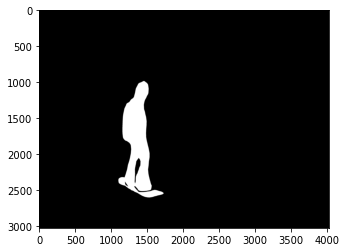

In [8]:
bw_mask_arr = vis_regions_to_file(
    image=image,
    boxes=r['rois'],
    masks=r['masks'],
    class_ids=r['class_ids'],
    class_names=class_names,
    scores=r['scores'],
    out_image_path=args.out,
)
from IPython.display import Image, display
# display(Image(bw))
plt.imshow(bw_mask_arr, cmap='gray')

In [9]:
from PIL import Image
bw_mask_img = Image.fromarray(bw_mask_arr, 'L')
bw_mask_img.save('bw.jpg')

In [10]:
del region_model  # RCNN not need

In [11]:
import torch
torch.cuda.empty_cache()

In [12]:
import gc
gc.collect()

824

In [13]:
SWAP_DIR = os.path.join(REPO_DIR, 'swapping-autoencoder-pytorch')
sys.path.append(SWAP_DIR)


In [19]:
from options import TestOptions
# todo: --result_dir
# struct = '/home/v/swapping-autoencoder-pytorch/testphotos/mountain/fig12/structure/IMG_1775.JPG'
# style = '/home/v/swapping-autoencoder-pytorch/testphotos/mountain/fig12/style/snow.jpeg'

struct = '/home/v/swapping-autoencoder-pytorch/testphotos/mountain/fig12/structure/snow-0.80.png'
style = '/home/v/swapping-autoencoder-pytorch/testphotos/mountain/fig12/style/greenlakerock.jpg'

struct = '/home/v/swapping-autoencoder-pytorch/testphotos/mountain/fig12/structure/IMG_1775.JPG'
style = '/home/v/swapping-autoencoder-pytorch/testphotos/mountain/fig12/style/greenlakerock.jpg'

sz=1024
alpha = ' '.join(str(round(0.01*i, 2)) for i in range(100))
opt = TestOptions().parse(command='_ _ --name mountain_pretrained --evaluation_metrics simple_swapping --input_structure_image "{struct}" --input_texture_image "{style}" --checkpoints_dir "{check}" --load_size {sz} --crop_size {sz} --preprocess scale_shortside --texture_mix_alpha {alpha}'.format(
    struct=struct,
    style=style,
    check=os.path.join(SWAP_DIR, "checkpoints"),
    sz=sz,
    alpha=alpha,
))

import data
import models
from evaluation import GroupEvaluator

dataset = data.create_dataset(opt)
evaluators = GroupEvaluator(opt)

style_model = models.create_model(opt)

evaluators.evaluate(style_model, dataset, opt.resume_iter)

parsing args...
using custom command
_ _ --name mountain_pretrained --evaluation_metrics simple_swapping --input_structure_image "/home/v/swapping-autoencoder-pytorch/testphotos/mountain/fig12/structure/IMG_1775.JPG" --input_texture_image "/home/v/swapping-autoencoder-pytorch/testphotos/mountain/fig12/style/greenlakerock.jpg" --checkpoints_dir "/home/v/neural-travel/swapping-autoencoder-pytorch/checkpoints" --load_size 1024 --crop_size 1024 --preprocess scale_shortside --texture_mix_alpha 0.0 0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2 0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28 0.29 0.3 0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4 0.41 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5 0.51 0.52 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.6 0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7 0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8 0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 0.89 0.9 0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99
----------------

{}

In [20]:
from PIL import ImageFilter

def mask_frame(styled_im, bw_mask_im, orig_im, blur_size=10) -> Image:
    orig_rs = orig.resize((styled_im.width, styled_im.height))
    bw_mask_rs = bw_mask_im.resize((styled_im.width, styled_im.height))
    bw_mask_rs = bw_mask_rs.filter(ImageFilter.BoxBlur(blur_size))

    bw_mask_rs_np = np.array(bw_mask_rs)
    orig_rs_np = np.array(orig_rs)
    styled_np = np.array(styled_im)

    t = orig_rs_np.copy()
    for c in range(3):
        t[:, :, c] = orig_rs_np[:, :, c] * (bw_mask_rs_np/255) + styled_np[:, :, c] * (1 - bw_mask_rs_np/255)
    t_img = Image.fromarray(t, 'RGB')
    return t_img


import os
out_folder = 'results/mountain_pretrained/frames'

for al in alpha.split():
    os.makedirs(out_folder, exist_ok=True)
    if len(al.split('.')[1]) == 1:
        al = al + '0'
    a = os.path.splitext(os.path.basename(struct))[0]
    b = os.path.splitext(os.path.basename(style))[0]
    im_path = 'results/mountain_pretrained/simpleswapping/{a}_{b}_{al}.png'.format(al=al, a=a, b=b)
    print(im_path)
    rr = Image.open(im_path)
    orig = Image.open(struct)
    frame_im = mask_frame(rr, bw_mask_img, orig)
    out_im_path = os.path.join(out_folder, '{al}.png'.format(al=al))
    frame_im.save(out_im_path)

results/mountain_pretrained/simpleswapping/IMG_1775_greenlakerock_0.00.png
results/mountain_pretrained/simpleswapping/IMG_1775_greenlakerock_0.01.png
results/mountain_pretrained/simpleswapping/IMG_1775_greenlakerock_0.02.png
results/mountain_pretrained/simpleswapping/IMG_1775_greenlakerock_0.03.png
results/mountain_pretrained/simpleswapping/IMG_1775_greenlakerock_0.04.png
results/mountain_pretrained/simpleswapping/IMG_1775_greenlakerock_0.05.png
results/mountain_pretrained/simpleswapping/IMG_1775_greenlakerock_0.06.png
results/mountain_pretrained/simpleswapping/IMG_1775_greenlakerock_0.07.png
results/mountain_pretrained/simpleswapping/IMG_1775_greenlakerock_0.08.png
results/mountain_pretrained/simpleswapping/IMG_1775_greenlakerock_0.09.png
results/mountain_pretrained/simpleswapping/IMG_1775_greenlakerock_0.10.png
results/mountain_pretrained/simpleswapping/IMG_1775_greenlakerock_0.11.png
results/mountain_pretrained/simpleswapping/IMG_1775_greenlakerock_0.12.png
results/mountain_pretrain